In [13]:
import xarray as xr
from dea_tools.temporal import xr_phenology
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
from glob import glob

In [14]:
# bucketname = 'sanca'
# version = '0.2'
# desc = 'cloud masked, gap filled with < 25 days'
# satellite = 'Landsat'

# ec2 = False

# save = False
# outds = False
# hist = False

In [51]:
farmgroupid = 'a5b9ae81-434a-4224-a81a-3c0ba44102b8'
source = 'LAI_mgap_90_w_7_v2.nc'

suffix = 'safra'
start = '06-20'
end = '03-15'

years = 0

# the metrics
basic_pheno_stats = [
    "SOS","vSOS","POS", "vPOS",
    "EOS", "vEOS","Trough", "LOS","AOS",
    "ROG","ROS"]
method_sos = "first"
method_eos = "last"

In [52]:
df = xr.open_dataset(f'/mnt/geodata/Clientes/0FARMS/{farmgroupid}/results/{source}')
folderout = f'/mnt/geodata/Clientes/0FARMS/{farmgroupid}/results/'
Path(f'{folderout}').mkdir( parents = True, exist_ok = True)

In [53]:
nextyear = 0
if years == 0:
    print('! years ok')
    
    if int(end[:2]) > int(start[:2]):
        print('o-o end > start: season start and finish in the same year \n    typically safrinha or northern hemisphere')#and int(end[:2]) < int(str(df.time.values[-1]).split('T')[0][5:7]):
        if int(end[:2]) > int(str(df.time.values[-1]).split('T')[0][5:7]):
            print('!!! you are asking for more than you have \n error: end > data.end')
        else:
            print('! you are good to go')
    else:
        nextyear = 1
        print('o-o it looks like you are looking at the tropics and southern hemisphere, \n    since your season go to the next year (+1)')

! years ok
o-o it looks like you are looking at the tropics and southern hemisphere, 
    since your season go to the next year (+1)


In [55]:
dates = []
for year in np.unique(df.time.dt.year)[:-1]:
    da = df['LAI'].sel(time=slice(f'{year}-{start}',f'{year+nextyear}-{end}'))
    da = da.compute()
    stats = xr_phenology( da, method_sos=method_sos, method_eos=method_eos, stats=basic_pheno_stats,
                    verbose=False )
    # add results to dict
    #datelabel = f'{year}-06-20'
    date = np.datetime64(f'{year}-{end}')
    dates.append(date)
    stats = stats.expand_dims(dim='time')
    stats.to_netcdf(f'{folderout}/phenology_{year}_{suffix}.nc')
    del da, stats


In [56]:
files = sorted(glob(f'{folderout}/phenology*{suffix}.nc'))
files

['/mnt/geodata/Clientes/0FARMS/a5b9ae81-434a-4224-a81a-3c0ba44102b8/results/phenology_2013_safra.nc',
 '/mnt/geodata/Clientes/0FARMS/a5b9ae81-434a-4224-a81a-3c0ba44102b8/results/phenology_2014_safra.nc',
 '/mnt/geodata/Clientes/0FARMS/a5b9ae81-434a-4224-a81a-3c0ba44102b8/results/phenology_2015_safra.nc',
 '/mnt/geodata/Clientes/0FARMS/a5b9ae81-434a-4224-a81a-3c0ba44102b8/results/phenology_2016_safra.nc',
 '/mnt/geodata/Clientes/0FARMS/a5b9ae81-434a-4224-a81a-3c0ba44102b8/results/phenology_2017_safra.nc',
 '/mnt/geodata/Clientes/0FARMS/a5b9ae81-434a-4224-a81a-3c0ba44102b8/results/phenology_2018_safra.nc',
 '/mnt/geodata/Clientes/0FARMS/a5b9ae81-434a-4224-a81a-3c0ba44102b8/results/phenology_2019_safra.nc',
 '/mnt/geodata/Clientes/0FARMS/a5b9ae81-434a-4224-a81a-3c0ba44102b8/results/phenology_2020_safra.nc',
 '/mnt/geodata/Clientes/0FARMS/a5b9ae81-434a-4224-a81a-3c0ba44102b8/results/phenology_2021_safra.nc',
 '/mnt/geodata/Clientes/0FARMS/a5b9ae81-434a-4224-a81a-3c0ba44102b8/results/phenol

In [57]:
DF = xr.open_mfdataset(files, concat_dim='time', combine='nested')
DF = DF.assign_coords({'time':dates})

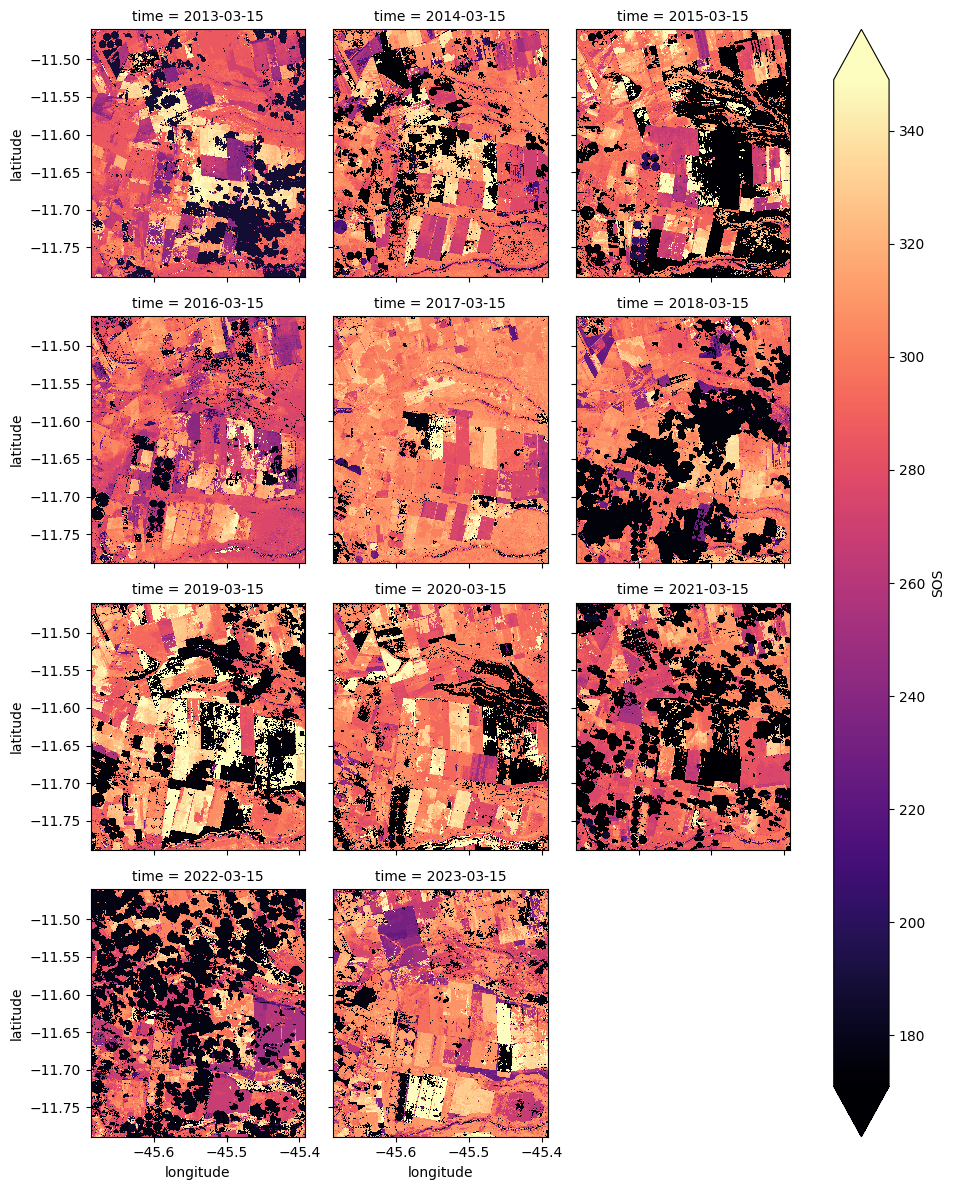

In [58]:
DF['SOS'].plot(col = 'time', col_wrap=3, robust=True, cmap = 'magma')

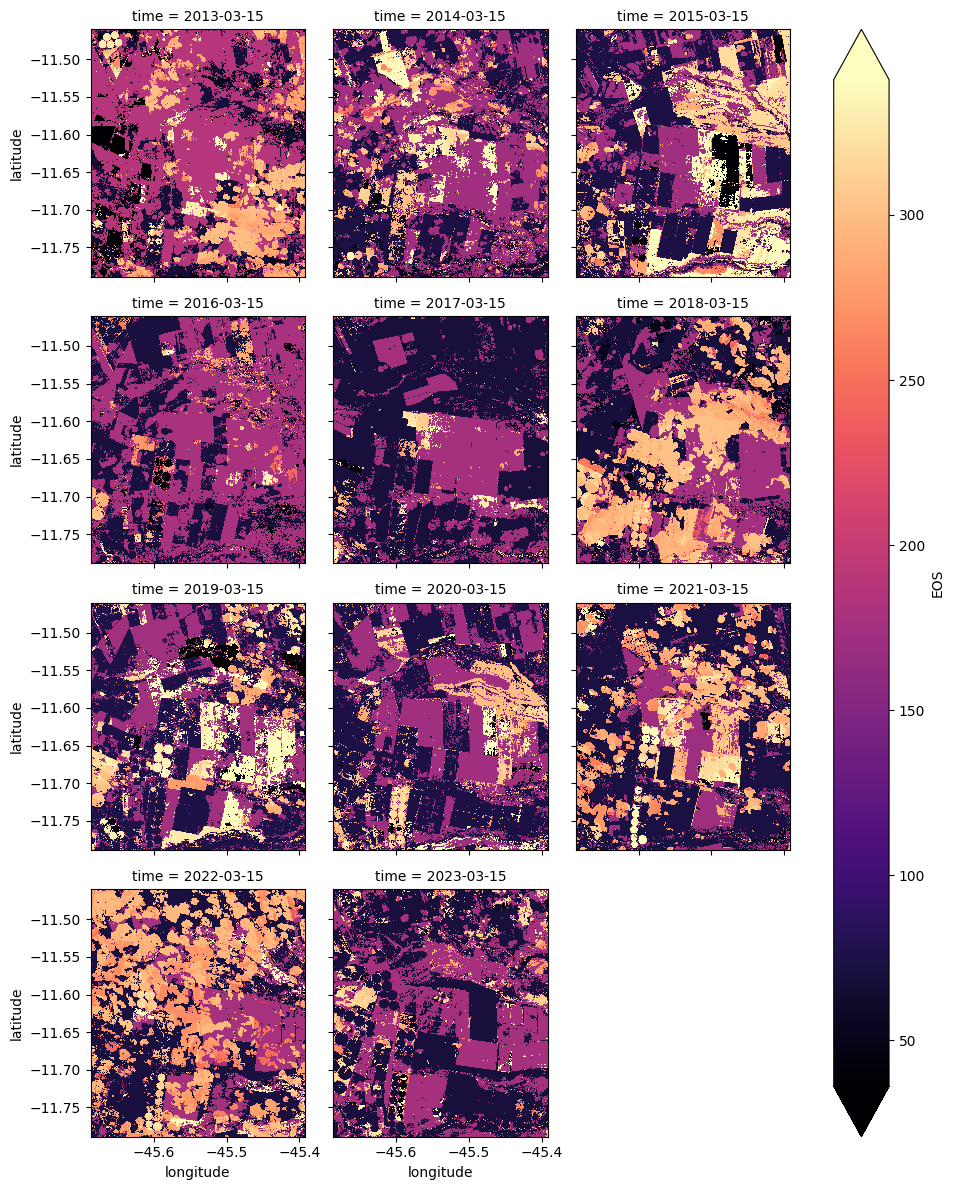

In [59]:
DF['EOS'].plot(col = 'time', col_wrap=3, robust=True, cmap = 'magma')

In [39]:
years

0

In [60]:
di, df = str(DF.time.values[0])[:4] , str(DF.time.values[-1])[:4]
print(di,df)

2013 2023


In [61]:
DF.to_netcdf(f'{folderout}/Phenology_{di}-{df}_{suffix}.nc')